## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular experssion
import nltk
from nltk.corpus import stopwords #stopwords are used to remve irrelevant words such as "is, to, so etc."
from nltk.stem.porter import PorterStemmer #Words are reduced to their root form such as "likes, liked, likely to be reduced to like"
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [2]:
#Lets read the given dataset 
messages = pd.read_csv("C:\\Users\\Namit\\SMSSpamCollection.txt", sep = "\t", names = ["Datalabel", "Message"])

In [3]:
#To check the structure of the dataset
messages.head()

,Datalabel,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Basic EDA

In [4]:
#spam and ham message count
messages.Datalabel.value_counts()

ham     4825
spam     747
Name: Datalabel, dtype: int64

### It can be easily noticed that, the data is imbalanced i.e. the dataset is in 6:1 ratio for HAM vs SPAM messages. 
CLASS IMBALANCE: Class imbalance can be found in many different areas like medical diagnosis, Spam filtering, fraud detection etc. The problem with class imbalance is that, it leads to Data Overfitting. To deal with imbalanced data resampling techniques can be used. There are various resampling techniques:
1) Random undersampling,
2) Random oversampling,
3) cluster based oversampling,
4) Informed oversampling.

In [5]:
messages.groupby("Datalabel").describe()

Message                                                            \
            count unique                                                top   
Datalabel                                                                     
ham          4825   4516                             Sorry, I'll call later   
spam          747    653  Please call our customer service representativ...   

                
          freq  
Datalabel       
ham         30  
spam         4

In [6]:
messages['length'] = messages['Message'].apply(len)
messages.head()

,Datalabel,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [7]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [8]:
messages[messages['length'] == 910]['Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Text(0.5, 1.0, 'SPAM AND HAM MESSAGE DISTRIBUTION')

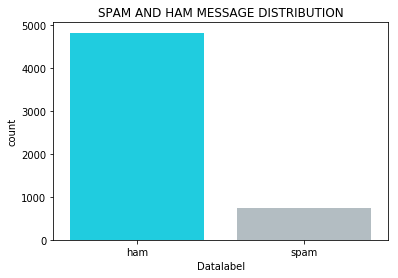

In [9]:
#distribution of spam and ham messages
sns.countplot(x="Datalabel", data=messages, palette=["#00e5ff", "#b0bec5"])
messages.loc[:, "Datalabel"].value_counts()
plt.title("SPAM AND HAM MESSAGE DISTRIBUTION")
#The following plot makes it quite clear that the data is highly imbalanced, so we have to take care of it as we proceed.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


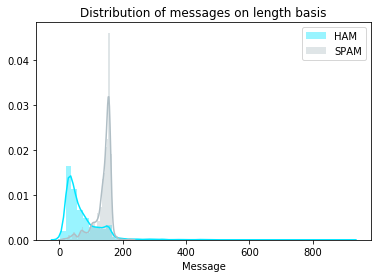

In [10]:
# Distribution of messages on length basis and it could be observed that, the longer message is more likely to be classified as SPAM one.
ham = messages[messages["Datalabel"]=="ham"]["Message"].str.len()
sns.distplot(ham, label="HAM", color="#00e5ff")

spam = messages[messages["Datalabel"]=="spam"]["Message"].str.len()
sns.distplot(spam, label="SPAM", color="#b0bec5")
plt.title("Distribution of messages on length basis")
plt.legend()

#### Distribution on the basis of length clearly showed that the longer the messages are, more likely they're falling in the SPAM category.

In [11]:
#frequently occuring words of ham and spam
ham_count = Counter(" ".join(messages[messages["Datalabel"]=="ham"]["Message"]).split()).most_common(40)
freq_ham_msgs = pd.DataFrame.from_dict(ham_count)
freq_ham_msgs = freq_ham_msgs.rename(columns = {0:"HAM WORDS", 1: "HAM WORD COUNT"})

spam_count = Counter(" ".join(messages[messages["Datalabel"]=="spam"]["Message"]).split()).most_common(40)
freq_spam_msgs = pd.DataFrame.from_dict(spam_count)
freq_spam_msgs = freq_spam_msgs.rename(columns = {0:"SPAM WORDS", 1: "SPAM WORD COUNT"})
freq_ham_msgs.head()

,HAM WORDS,HAM WORD COUNT
0,to,1538
1,you,1462
2,I,1439
3,the,1029
4,a,977


In [12]:
freq_spam_msgs.head()

,SPAM WORDS,SPAM WORD COUNT
0,to,607
1,a,360
2,your,187
3,call,185
4,or,185


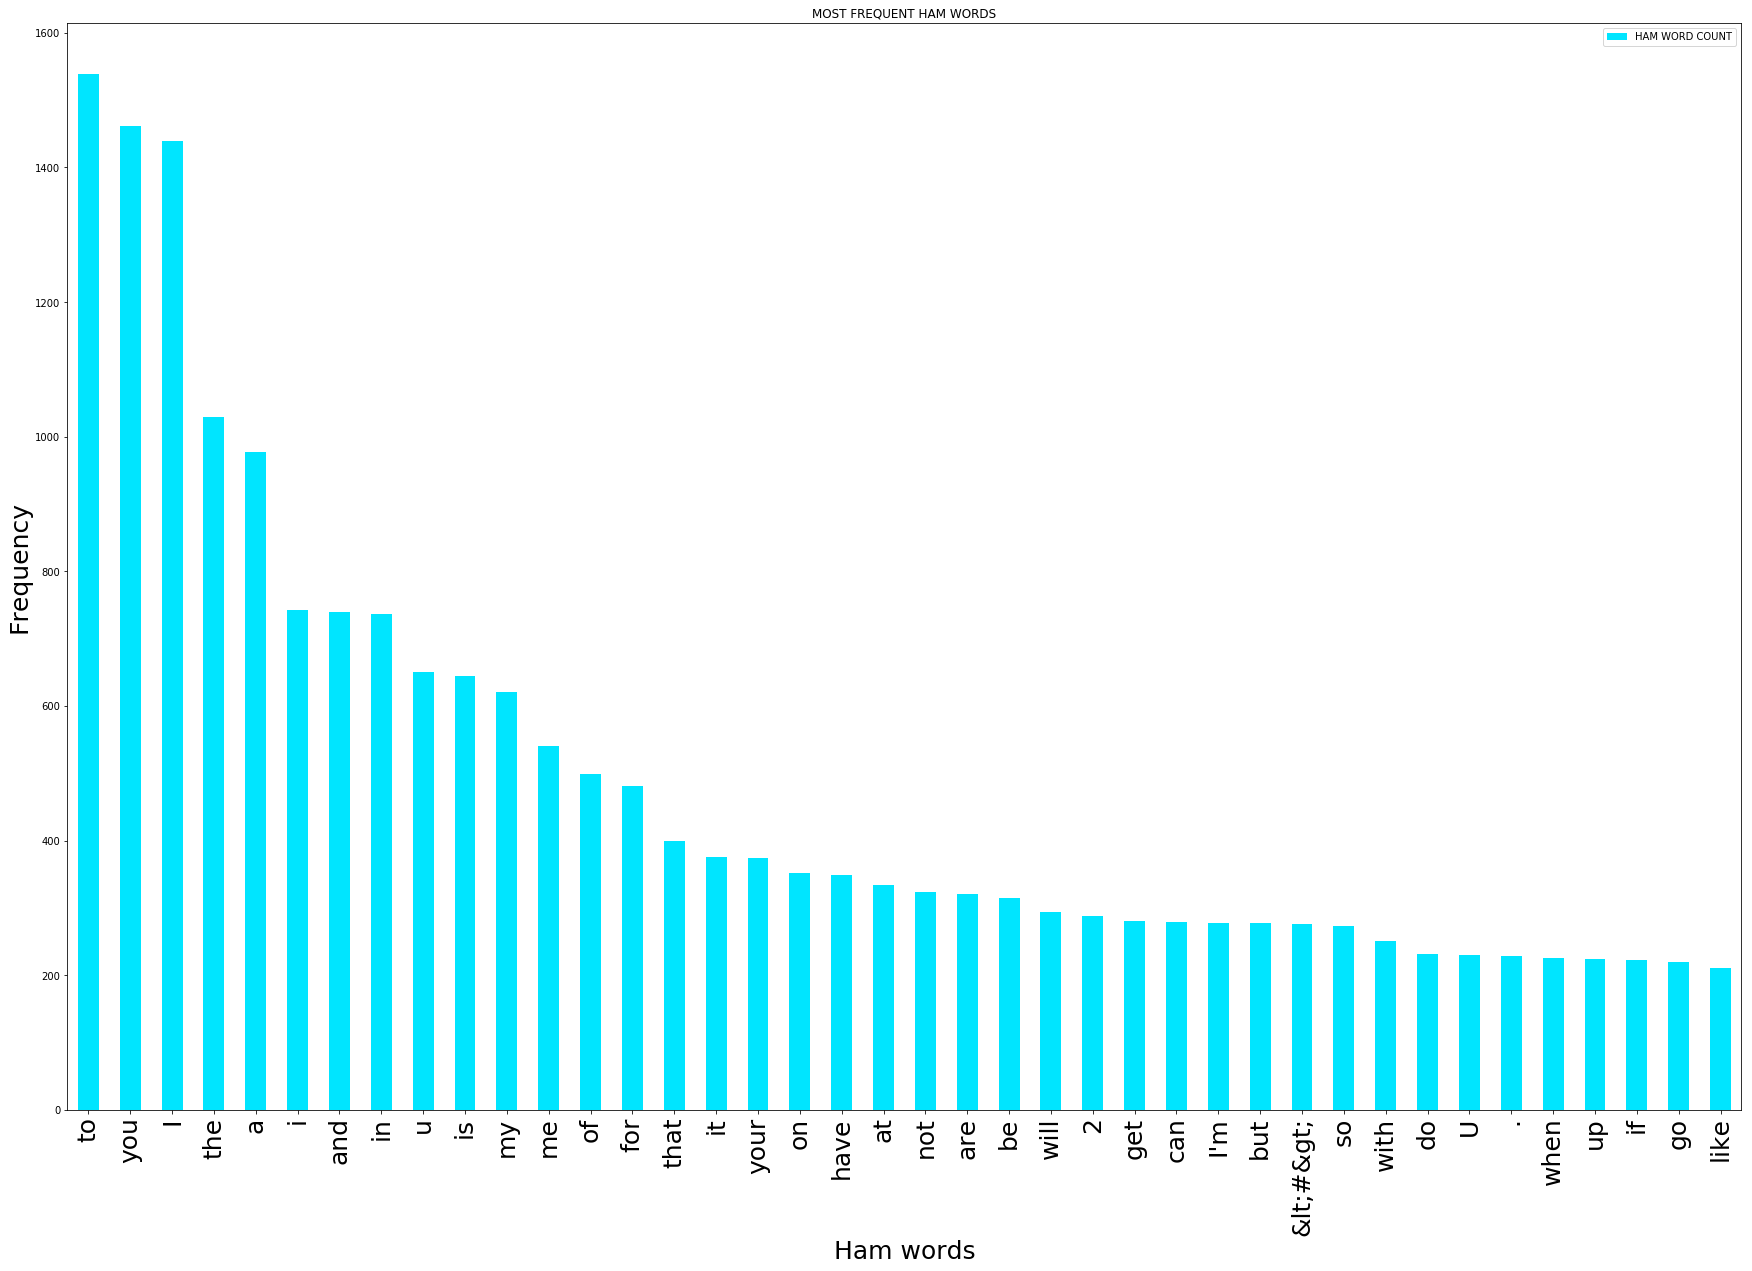

In [13]:
#Lets plot for Frequently occuring words under HAM label
freq_ham_msgs.plot.bar(legend = "False", color="#00e5ff", figsize=(30,20))
y= np.arange(len(freq_ham_msgs["HAM WORDS"]))
plt.xticks(y, freq_ham_msgs["HAM WORDS"], fontsize=25)
plt.title("MOST FREQUENT HAM WORDS")
plt.xlabel("Ham words", fontsize=25)
plt.ylabel("Frequency", fontsize=25)
plt.show()

##### The above graph shows the frequency of most frequent words under HAM label and the graph below shows the frequency of most frequent words under SPAM label.

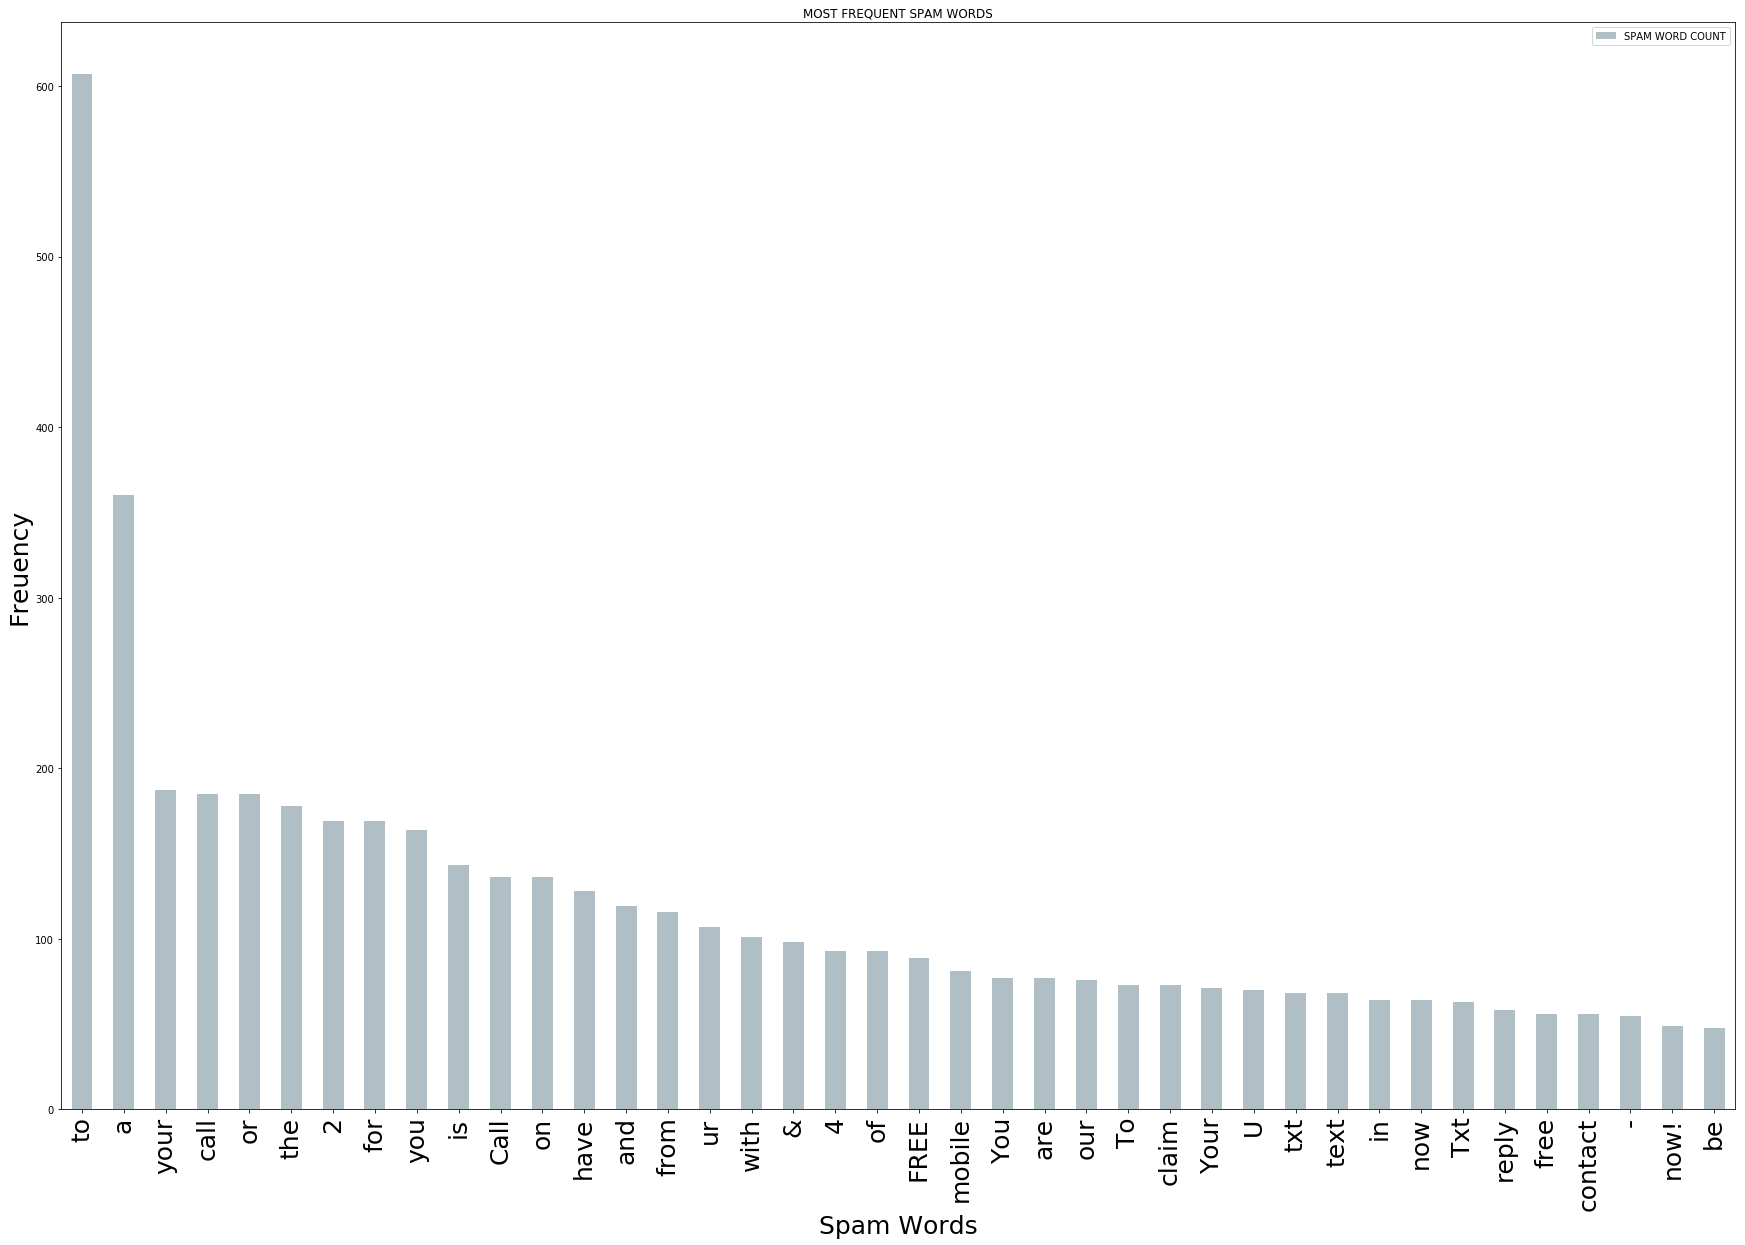

In [14]:
#Lets plot for Frequently occuring words under SPAM label
freq_spam_msgs.plot.bar(legend = "False", color="#b0bec5", figsize=(30,20))
y= np.arange(len(freq_spam_msgs["SPAM WORDS"]))
plt.xticks(y, freq_spam_msgs["SPAM WORDS"], fontsize=25)
plt.title("MOST FREQUENT SPAM WORDS")
plt.xlabel("Spam Words", fontsize=25)
plt.ylabel("Freuency", fontsize=25)
plt.show()

## DATA PREPARATION
The main issue with the given data is that it is in the form of strings and the classification ML algorithms require numerical data. But to deal with this, there are many methods to convert a corpus to a vector format. One of them is Bag Of Words approach in which each unique word is represented by a number.

In [15]:
nltk.download("stopwords")
#stopwords in nltk helps in removing unnecessary words like a, an, the, is etc.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Namit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
#stemming is used to normalize text data such as "likely" or "liked" would be changed to their root word "like"
ps = PorterStemmer()

In [17]:
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Message'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [20]:
corpus

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun',
 'winner valu network custom select receivea prize reward claim call claim code kl valid hour',
 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free',
 'gonna home soon want talk stuff anymor tonight k cri enough today',
 'six chanc win cash pound txt csh send cost p day day tsandc appli repli hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw',
 'search right word thank breather

In [55]:
with open("corpus_list.txt", "w") as f:
    f.writelines("%s\n"  % corpus_list for corpus_list in corpus)

In [56]:
corpus_list = []
with open("corpus_list.txt", "r") as f:
    filecontents = f.readlines()
    for line in filecontents:
        #To remove line break
        current_point = line[:-1]
        corpus_list.append(current_point) 

In [57]:
corpus_list

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun',
 'winner valu network custom select receivea prize reward claim call claim code kl valid hour',
 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free',
 'gonna home soon want talk stuff anymor tonight k cri enough today',
 'six chanc win cash pound txt csh send cost p day day tsandc appli repli hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw',
 'search right word thank breather

In [58]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_list).toarray()

In [59]:
X.shape

(5572, 6296)

In [60]:
y=pd.get_dummies(messages['Datalabel'])
y=y.iloc[:,1].values

In [61]:
y=pd.get_dummies(messages['Datalabel'])
y.head(20)
#1 for SPAM and 0 for HAM

,ham,spam
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
5,0,1
6,1,0
7,1,0
8,0,1
9,0,1


In [62]:
y=y.iloc[:,1].values

In [63]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [64]:
X[0].shape

(6296,)

In [65]:
X[21].shape

(6296,)

In [66]:
y #0 means Ham 1 means Spam

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [67]:
print("size X dataset", X.shape)
print("size y dataset", y.shape)

size X dataset (5572, 6296)
size y dataset (5572,)


In [68]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

Before OverSampling, counts of label '1': 747
Before OverSampling, counts of label '0': 4825 



In [69]:
#CLASS BALANCING to deal with the imbalanced data so that equal intances are created and the proposed model could avoid the problem of overfitting due to less exposure towards minority data. To do so, Synthetic Minorty Oversampling TEchnique is used, also known as SMOTE. SMOTE generates synthetic samples from the minority class.
sm = SMOTE(random_state=50)
X_res, y_res = sm.fit_sample(X, y.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [70]:
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

After OverSampling, the shape of train_X: (9650, 6296)
After OverSampling, the shape of train_y: (9650,) 

After OverSampling, counts of label '1': 4825
After OverSampling, counts of label '0': 4825


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20, random_state = 0)

## MODEL TRAINING AND TESTING

### NAIVE BAYES

In [72]:
print("After OverSampling, counts of label '1': {}".format(sum(y_test==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_test==0)))

After OverSampling, counts of label '1': 988
After OverSampling, counts of label '0': 942


In [73]:
# Training model using Naive bayes classifier
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

In [74]:
c_matrix = confusion_matrix(y_test, y_pred)

In [75]:
c_matrix

array([[924,  18],
       [161, 827]], dtype=int64)

In [76]:
print('Naive Bayes Accuracy: ',accuracy_score(y_test,y_pred))
a_score = accuracy_score(y_test, y_pred)

Naive Bayes Accuracy:  0.9072538860103627


### DECISION TREE CLASSIFIER

In [77]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_split=7, random_state=50)
dtc.fit(X_train, y_train)
y_pred_dtree = dtc.predict(X_test)

print('Decision Tree Accuracy: ',accuracy_score(y_test,y_pred_dtree))
print('Decision Tree confusion_matrix: ', confusion_matrix(y_test, y_pred_dtree)) 

Decision Tree Accuracy:  0.9352331606217616
Decision Tree confusion_matrix:  [[833 109]
 [ 16 972]]


### RANDOM FOREST 

In [78]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=37, random_state=50)
# n_estimators is used for the number of trees you want to build before taking the maximum voting or average of predictions
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print('Random Forest Accuracy_score: ',accuracy_score(y_test,y_pred_rfc))
print('Random Forest confusion_matrix: ', confusion_matrix(y_test, y_pred_rfc))

Random Forest Accuracy_score:  0.9409326424870467
Random Forest confusion_matrix:  [[835 107]
 [  7 981]]


In [79]:
#saving the best model we got
import pickle
filename = "final_spam_vs_ham_model.pickle"
pickle.dump(rfc, open(filename, "wb"))

In [80]:
message = input("Input a message")
filename = "final_spam_vs_ham_model.pickle"
nltk.download("stopwords")
ps = PorterStemmer()

Input a messageWhat is up brother? How are you doing? Everything good with you?


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Namit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:

rev = re.sub("[^a-zA-Z]", " ", message)
rev = rev.lower()
rev = rev.split()
rev = [ps.stem(word) for word in rev if not word in stopwords.words("english")]
rev = " ".join(rev)
corp = [rev]

In [82]:
corp

['brother everyth good']

In [83]:
cv = CountVectorizer()
use = cv.fit_transform(corpus).toarray()
use

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [84]:
use.shape

(5572, 6296)

In [85]:
x = cv.transform(corp).toarray() #Dont forget to use the same instance of CountVectorizer that was used to train the model otherwise the number of features do not match is encountered
x

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [86]:
x.shape

(1, 6296)

In [87]:
loaded_model = pickle.load(open(filename, 'rb'))
#prediction begins now
prediction = loaded_model.predict(x)
if prediction[0]==0:
    print("HAM MESSAGE")
else:
    print("SPAM")

HAM MESSAGE
